In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

print(float_data)

[[ 9.9652e+02 -8.0200e+00  2.6540e+02 ...  1.0300e+00  1.7500e+00
   1.5230e+02]
 [ 9.9657e+02 -8.4100e+00  2.6501e+02 ...  7.2000e-01  1.5000e+00
   1.3610e+02]
 [ 9.9653e+02 -8.5100e+00  2.6491e+02 ...  1.9000e-01  6.3000e-01
   1.7160e+02]
 ...
 [ 9.9982e+02 -3.1600e+00  2.7001e+02 ...  1.0800e+00  2.0000e+00
   2.1520e+02]
 [ 9.9981e+02 -4.2300e+00  2.6894e+02 ...  1.4900e+00  2.1600e+00
   2.2580e+02]
 [ 9.9982e+02 -4.8200e+00  2.6836e+02 ...  1.2300e+00  1.9600e+00
   1.8490e+02]]


In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5 ,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5 ,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

2022-09-01 16:33:57.438433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-01 16:33:57.460847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-01 16:33:57.461279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-01 16:33:57.461851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/20


/tmp/ipykernel_2049/4158770318.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)
2022-09-01 16:34:01.324690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-01 16:34:01.962181: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-01 16:34:02.076280: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


500/500 [==============================] - 16s 26ms/step - loss: 0.4149 - val_loss: 0.4412
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3638 - val_loss: 0.4477
Epoch 3/20
500/500 [==============================] - 14s 27ms/step - loss: 0.3407 - val_loss: 0.4546
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3214 - val_loss: 0.4625
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3105 - val_loss: 0.4503
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.3013 - val_loss: 0.4596
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2933 - val_loss: 0.4745
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2863 - val_loss: 0.4556
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2797 - val_loss: 0.4617
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2741 - val_los

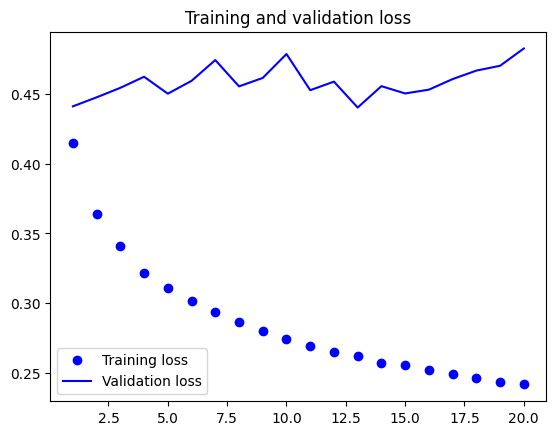

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
lookback = 1440
step = 3
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/tmp/ipykernel_2049/510135830.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)


  8/500 [..............................] - ETA: 21:05 - loss: 0.4610

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()